In [1]:
%run util.py

In [2]:
# N = 2
# N = 3
# N = 4
N = 5

In [3]:
# mu_0: the initial distribution; 1 x (N**2) 
# mu: the actual stationary distribution; 1 x (N**2)
# mu_1: the estimated stationary distribution 
# P: the new transition matrix (the old transition matrix is Q)
# G_1: the estimate of the gradient
# H_1: the estimate of the Hessian
# U_1: an estimated sample path of the Gaussian random vector U; length 1000

mu_0, mu, mu_1, P, G_1, H_1, U_1 = ChainGen(N)  # P is the ground truth transition matrix
mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = ChainGen(N)  # PP is a different transition matrix for testing purposes
zdump([N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P], 'P_PP_%d.pkz'%N)

<string>:372: RuntimeWarning: covariance is not positive-semidefinite.


In [4]:
N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = zload('P_PP_%d.pkz'%N)

In [5]:
mu

array([ 0.02041656,  0.1095335 ,  0.00047929,  0.01448225,  0.03510045,
        0.04025447,  0.05758942,  0.03667535,  0.04944635,  0.07902417,
        0.06520382,  0.018093  ,  0.02806803,  0.03591015,  0.01242936,
        0.03966927,  0.03996701,  0.01858294,  0.0380648 ,  0.03159664,
        0.01446792,  0.03780684,  0.07589874,  0.02997711,  0.07126256])

In [6]:
muP

array([ 0.01291442,  0.05226818,  0.04067492,  0.00692483,  0.00420529,
        0.0561179 ,  0.11260439,  0.0247669 ,  0.06772984,  0.01855608,
        0.01688867,  0.01521695,  0.07759541,  0.04371914,  0.09033036,
        0.0048744 ,  0.0307849 ,  0.09366857,  0.00852918,  0.05239034,
        0.02619224,  0.06890068,  0.00704474,  0.06334441,  0.00375727])

In [7]:
n_range = range(30, 60, 10)
# n_range = range(30, 90, 20)
# n_range = range(40, 130, 30)
# n_range = range(50, 170, 40)

In [8]:
num_test_sample = 2000
beta_list = list(np.arange(0, 0.2, 0.01)[1:-1]) + list(np.arange(0.2, 1.01, 0.05)[:-1])

In [9]:
beta_list

[0.01,
 0.02,
 0.029999999999999999,
 0.040000000000000001,
 0.050000000000000003,
 0.059999999999999998,
 0.070000000000000007,
 0.080000000000000002,
 0.089999999999999997,
 0.10000000000000001,
 0.11,
 0.12,
 0.13,
 0.14000000000000001,
 0.14999999999999999,
 0.16,
 0.17000000000000001,
 0.17999999999999999,
 0.20000000000000001,
 0.25,
 0.29999999999999999,
 0.34999999999999998,
 0.39999999999999997,
 0.44999999999999996,
 0.49999999999999994,
 0.54999999999999993,
 0.59999999999999987,
 0.64999999999999991,
 0.69999999999999996,
 0.74999999999999978,
 0.79999999999999982,
 0.84999999999999987,
 0.89999999999999991,
 0.94999999999999973]

In [10]:
eta_wc = {}
eta_Sanov = {}
test_sample = {}
for n in n_range:
    # Get sample paths of the Markov chain with length n; 
    # these paths will be the test set
    test_sample[str(n)] = []
    for idx in range(int(num_test_sample/2)):
        test_sample[str(n)].append(chain(mu, P, n))  
    for idx in range(int(num_test_sample/2)):
        test_sample[str(n)].append(chain(muP, PP, n))  
    # Get thresholds for Hoeffding's test corresponding to sample length n    
    for beta in beta_list:
        key = str(n) + '_' + str(beta)
        eta_1 = ThresWeakConv(N, beta, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
        eta_2 = ThresSanov(N, beta, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
        eta_wc[key] = eta_1
        eta_Sanov[key] = eta_2
zdump([test_sample, eta_wc, eta_Sanov], 'testSample_threshold_%d.pkz'%N)

In [11]:
test_sample, eta_wc, eta_Sanov = zload('testSample_threshold_%d.pkz'%N)

In [12]:
from __future__ import division

mu = np.reshape(mu, (N, N))

TPR_wc = {}
FPR_wc = {}
TPR_Sanov = {}
FPR_Sanov = {}

for n in n_range:
    for beta in beta_list:
        TP_wc = 0
        FP_wc = 0
        TP_Sanov = 0
        FP_Sanov = 0
        key = str(n) + '_' + str(beta)
        for idx in range(num_test_sample):
            KL = KL_est(test_sample[str(n)][idx], mu)
            if idx > 1000 and KL > eta_wc[key]:
                TP_wc += 1
            if idx < 1000 and KL > eta_wc[key]:
                FP_wc += 1
            if idx > 1000 and KL > eta_Sanov[key]:
                TP_Sanov += 1
            if idx < 1000 and KL > eta_Sanov[key]:
                FP_Sanov += 1
        TPR_wc[key] = TP_wc / 1000
        FPR_wc[key] = FP_wc / 1000
        TPR_Sanov[key] = TP_Sanov / 1000
        FPR_Sanov[key] = FP_Sanov / 1000
        
zdump([TPR_wc, FPR_wc, TPR_Sanov, FPR_Sanov], 'ROCpt_%d.pkz'%N)

In [13]:
TPR_wc, FPR_wc, TPR_Sanov, FPR_Sanov = zload('ROCpt_%d.pkz'%N)

In [14]:
TPR_wc_list = {}
FPR_wc_list = {}
TPR_Sanov_list = {}
FPR_Sanov_list = {}
        
for n in n_range:
    TPR_wc_list[str(n)] = []
    FPR_wc_list[str(n)] = []
    TPR_Sanov_list[str(n)] = []
    FPR_Sanov_list[str(n)] = []
    TPR_wc_list[str(n)].append(0)
    FPR_wc_list[str(n)].append(0)
    TPR_Sanov_list[str(n)].append(0)
    FPR_Sanov_list[str(n)].append(0)
    for beta in beta_list:
        key = str(n) + '_' + str(beta)
        TPR_wc_list[str(n)].append(TPR_wc[key])
        FPR_wc_list[str(n)].append(FPR_wc[key])
        TPR_Sanov_list[str(n)].append(TPR_Sanov[key])
        FPR_Sanov_list[str(n)].append(FPR_Sanov[key])

    TPR_wc_list[str(n)].append(1)
    FPR_wc_list[str(n)].append(1)
    TPR_Sanov_list[str(n)].append(1)
    FPR_Sanov_list[str(n)].append(1)

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


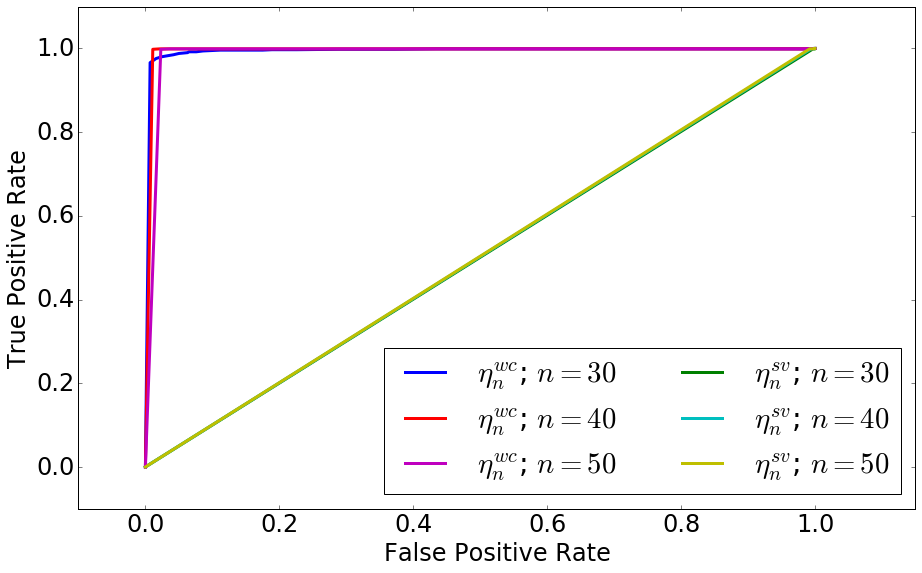

In [15]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  

ROC_WC_list = []
ROC_Sanov_list = []
style_list = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-']
idx = 0

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

plt.figure(figsize=(15,9))

matplotlib.rc('font', **font)

pylab.xlim(-0.1, 1.15)
pylab.ylim(-0.1, 1.1)

for n in n_range:
    ROC_WC_list.append(plt.plot(FPR_wc_list[str(n)], TPR_wc_list[str(n)], style_list[idx], linewidth=3))
    ROC_Sanov_list.append(plt.plot(FPR_Sanov_list[str(n)], TPR_Sanov_list[str(n)], style_list[idx+1], linewidth=3))
    idx += 2

legend_list_1 = []
legend_list_2 = []
legend_list_1.append(ROC_WC_list)
legend_list_1.append(ROC_Sanov_list)
legend_list_1 = list(np.array(legend_list_1).ravel())

for n in n_range:
    legend_list_2.append("$\eta_n^{wc}$; $n=%d$"%n)
for n in n_range:
    legend_list_2.append("$\eta_n^{sv}$; $n=%d$"%n)
plt.legend(legend_list_1, legend_list_2, ncol=2, loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.grid()


savefig('ROC_%d.eps'%N)

plt.show()